The following file reads a number of files in a specific format "heightmaps_sequence-?_impacts-?_coverage-?.csv"
where ? are integers representing different samples for the numerical simuilation. 
Then the conventional as well as persistence parameters are calculated.

1) Section: 
The values of the hyperparameters are extracted and the values on the grids specified in the files are saved.

2) For an analysis we need to interpolate the samples on a regular grid.

3) Estimate coverage values

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# import path variables
from src.config import data_path_raw_simulation, data_path_interim
# import simulation parameters
from src.config import simulation_parameters

# import the read and check method files
from src.preprocess.read_simulation_files import (read_heightmaps_sequences, check_if_regulargrid,
    interpolate_grid, interpolate_regular_grid)


# 1) Read and inteprolate

Read numerical Simulation csv-files and interpolate them on a regular grid for different approaches.

## Read

Read the csv files in the dir_read_path and create lists of z-values, 
x-values and y-values as well as a dataframe grabbing the coverage 
class, sequence number as well as number of impacts from the filenames.

Since the coverage classes are not representative of the actual coverage values they will be replaced later on.

In [18]:
# read all csv files for the different files for the numerical simulation
z, x, y, df_info = read_heightmaps_sequences(data_path_raw_simulation,
                                             z_name='U3',
                                             x_name='x',
                                             y_name='y')

# change the coverage values contained in the filenames of the
# heightmap to have it for later
df_info['coverage_old'] = df_info['coverage'].values

fn = f'surface_numSimulation_information_{simulation_parameters["calculation_method"]}.csv'
df_info.to_csv(data_path_interim / fn,
               index=False)

Let us check if the grids in x and y are regular ones and if their spacing is the same.

In [19]:
check = np.array([x[i] == x[0] for i in range(x.shape[0])])
print('Are all x_grids the same?', check.all())
check = np.array([y[i] == y[0] for i in range(x.shape[0])])
print('Are all y_grids the same?', check.all())

check = np.array([check_if_regulargrid(x[i], y[i])
                    for i in range(x.shape[0])])
print('Do we have regular grids:', check.all())

# Just for all purposes (must be one)
assert np.array([len(np.unique(np.diff(x[i], axis=0)))
                == 1 for i in range(x.shape[0])]).all()
assert np.array([len(np.unique(np.diff(y[i], axis=1)))
                == 1 for i in range(y.shape[0])]).all()

check = np.array([len(np.unique(np.diff(x[i], axis=1)))
                    == 1 for i in range(x.shape[0])])
print('Are all x_grids evenely spaced?', check.all())
check = np.array([len(np.unique(np.diff(y[i], axis=0)))
                    == 1 for i in range(y.shape[0])])
print('Are all y_grids evenely spaced?', check.all())

Are all x_grids the same? False
Are all y_grids the same? False
Do we have regular grids: True
Are all x_grids evenely spaced? False
Are all y_grids evenely spaced? False


# 2) Interpolate to get regular grid

Transform the different regular but unevenly spaced grids into heightmaps on regular, evenly spaced grids.

To reduce the fact this interpolation increase the size of the grids by an multiple of the current grid size.

Among others we can choose two different interpolation strategies using scipy:

1. griddata for unstructured data; works for any kind of data
--> use **interpolate_grid**
2. InterpolateRegularGrid; does a linear interpolation of data on a regular but possibly unevenly spaced grid.
Extrapolation is done via the nearest neighbour method.
--> use **interpolate_regular_grid**

The grids for the numerical simulation have different min/max borders:
Hence we interpolate on the smallest grid in the array of grids.

In [20]:
# use a interpolation size so that we are close to the grid values of the 
# original 74x74 grids. Using np.linspace in interpolate_regular_grid, 
# the intrpolation_size giving the same grid values for an evenly spaced
# regular grid, is:

# interpolation_size = 1+73*14

if simulation_parameters['interpolation_size_preprocess'] == 0:
    znew = z
    if y.ndim == 3:
        ynew = y[0]
    elif y.ndim == 2:
        ynew = y
    if x.ndim == 3:
        xnew = x[0]
    elif x.ndim == 2:
        xnew = x

else:
    znew, xnew, ynew = interpolate_regular_grid(z, x, y, 
                            simulation_parameters['interpolation_size_preprocess'], 
                            bigger_grid=simulation_parameters['bigger_grid'])

# save the interpolated surface data
fn = f'surface_numSimulation_{simulation_parameters["calculation_method"]}.npz'
np.savez(data_path_interim / fn,
         values = znew,
         x_grid = xnew,
         y_grid = ynew)

# 3) Estimate the coverage values

The provided coverage classes are very coarse estimates of the coverage values of the samples. To check if using the different stages as classes (and group the samples in 6th stage for the 7-sample-long-sequences to the 100% coverage class), we approximate the coverages of the samples using following pipeline:
1. Approximate local minima of the samples
2. Using these local minima, draw circles around them of radius 0.055mm having the local minima as center
3. Take the union of these circles and ...
4. ...intersect this union with the larger circle of radius 0.2mm
5. The ration of this intersection within the larger circle is the coverage percentage

6. Due to the coverage evolution model, the last slide is considered to be 100% coverage. The approximated coverage values do not exhibit this behaviour. To account for inaccuracies during the modelling process and account for certain restrictions, we normalize the different coverage values by taking the ratio of each sample for each sequence by the coverage value of the last sample -the one representing 100%.

In [22]:
# load data, get the according values (and delete the loaded data again?)
data = np.load(data_path_interim / f'surface_numSimulation_{simulation_parameters["calculation_method"]}.npz')
znew = data['values']
xnew = data['x_grid']
ynew = data['y_grid']

fn = f'surface_numSimulation_information_{simulation_parameters["calculation_method"]}.csv'
df_info = pd.read_csv(data_path_interim / fn)

In [23]:
from src.preprocess.approximate_coverage import get_local_minima

# size of the indent circles and the larger circle
radius_indent = 0.055/2
radius_circ = 0.2/2

# important to guaranteu that certain points can be a little bit closer than the complete circle
eps = 0.005 

minima_arr = get_local_minima(z=znew, 
                              grid=xnew, 
                              radius_indent=radius_indent,
                              eps=eps,
                              df_info=df_info)

In [24]:
from src.preprocess.approximate_coverage import approximate_coverage

coverage_list, mask_list =\
    approximate_coverage(minima_arr=minima_arr,
                         xgrid=xnew,
                         ygrid=ynew,
                         radius_circ=radius_circ, 
                         radius_indent=radius_indent,
                         df_info=df_info)

Calculate the normalized coverage

In [25]:
coverage_normalized = []

# run through all sequences
for seq in np.unique(df_info['sequence']):
    # select the sequence at hand
    df_tmp = df_info.loc[(df_info['sequence']==seq)]
    idx = df_tmp.loc[:, 'id'].values
    
    # get the sample in the last stage (maximal impacts) in each sequence
    idx_last = df_tmp.loc[:, 'id'].values[np.argmax(df_tmp.loc[:, 'impacts'])]
    
    # divide the coverage of the coverage sample at last stage from the others
    for i in range(len(idx)):
        cov = np.sum(mask_list[idx[i]])/np.sum(mask_list[idx_last])
        coverage_normalized.append(cov)

df_info['coverage_normalized'] = np.array(coverage_normalized)

Check if we have clear different classes (using the old coverage values):

In [26]:
df_test = df_info[['coverage_old', 'coverage_normalized']].groupby('coverage_old').agg({'coverage_normalized': ['min', 'mean', 'max']})
print(df_test)

             coverage_normalized                    
                             min      mean       max
coverage_old                                        
16                      0.304963  0.367645  0.379771
33                      0.633567  0.689691  0.716538
50                      0.842306  0.883085  0.907241
66                      0.940468  0.964906  0.978370
83                      0.990191  0.994357  0.998457
100                     0.998794  0.999912  1.000000


Check if there is any overlap between these classes (ordered by the old_coverages). 

If there is no overlap we can safely use these as our new classes and can 
use digitize to get the bins. Mean values are the labels for the new covergage classes.

In [27]:
# check if it's fitting the coverage values
test_min = df_test[('coverage_normalized', 'min')].values
test_mean = df_test[('coverage_normalized', 'mean')].values
test_max = df_test[('coverage_normalized', 'max')].values

overlap = False
bins = []
mean_coverages = []
for i in range(test_min.shape[0]-1):
    if test_max[i] >= test_min[i+1]:
        print(f'Thresholds are overlapping for {i}')
        overlap = True
    else:
        bins.append( test_max[i]+(test_min[i+1]- test_max[i])/2)
        mean_coverages.append(np.round(100*test_mean[i]))

if not overlap:
    print('No overlap!')
    # add 100% class to mean_coverages, since we do not include it yet
    mean_coverages.append(100)
    mean_coverages = np.array(mean_coverages).astype('int')
    
    inds = np.digitize(df_info['coverage_normalized'].values, bins)
    df_info['coverage_labels'] = inds
    df_info['coverage'] = mean_coverages[inds]

print('bins:', bins)
print('mean coverages:', mean_coverages)

No overlap!
bins: [0.5066693556082923, 0.7794219807114433, 0.9238545876953528, 0.9842803376992575, 0.9986257079119547]
mean coverages: [ 37  69  88  96  99 100]


Overwrite the existing df_info with the new information:

In [28]:
fn = f'surface_numSimulation_newcoverage_{simulation_parameters["calculation_method"]}.csv'
df_info.to_csv(data_path_interim / fn,
               index=False)

# Visualize

Show a plot of **all** numerical simulation samples ordered by their different sequences in the rows and their different stages / times when snapshots are taken during the coverage evolution of the FE model:

In [ ]:
# sequences = np.unique(df_info['sequence'])
# num_impacts = df_info.groupby(by='sequence').size().max()

# fig, ax = plt.subplots(len(sequences), num_impacts,
#                        dpi=100, figsize=(20, 45))

# for seq_i, seq in enumerate(sequences):
#     for imp_j, imp in enumerate(df_info.\
#         loc[df_info['sequence']==seq, 'impacts'].values):
#         #
#         idx = df_info.loc[(df_info['sequence']==seq) 
#                           & (df_info['impacts']==imp),
#                           'id'].values[0]
#         ax[seq_i, imp_j].imshow(znew[idx])
#         ax[seq_i, imp_j].axis('off')
        
#         ax[seq_i, imp_j].set_title(f's:{seq}, i:{imp}')
        
#     if imp_j < num_impacts:
#         ax[seq_i, num_impacts-1].axis('off')

# fig.tight_layout()

Show the plots for detecting of local minima and the coverage approximation

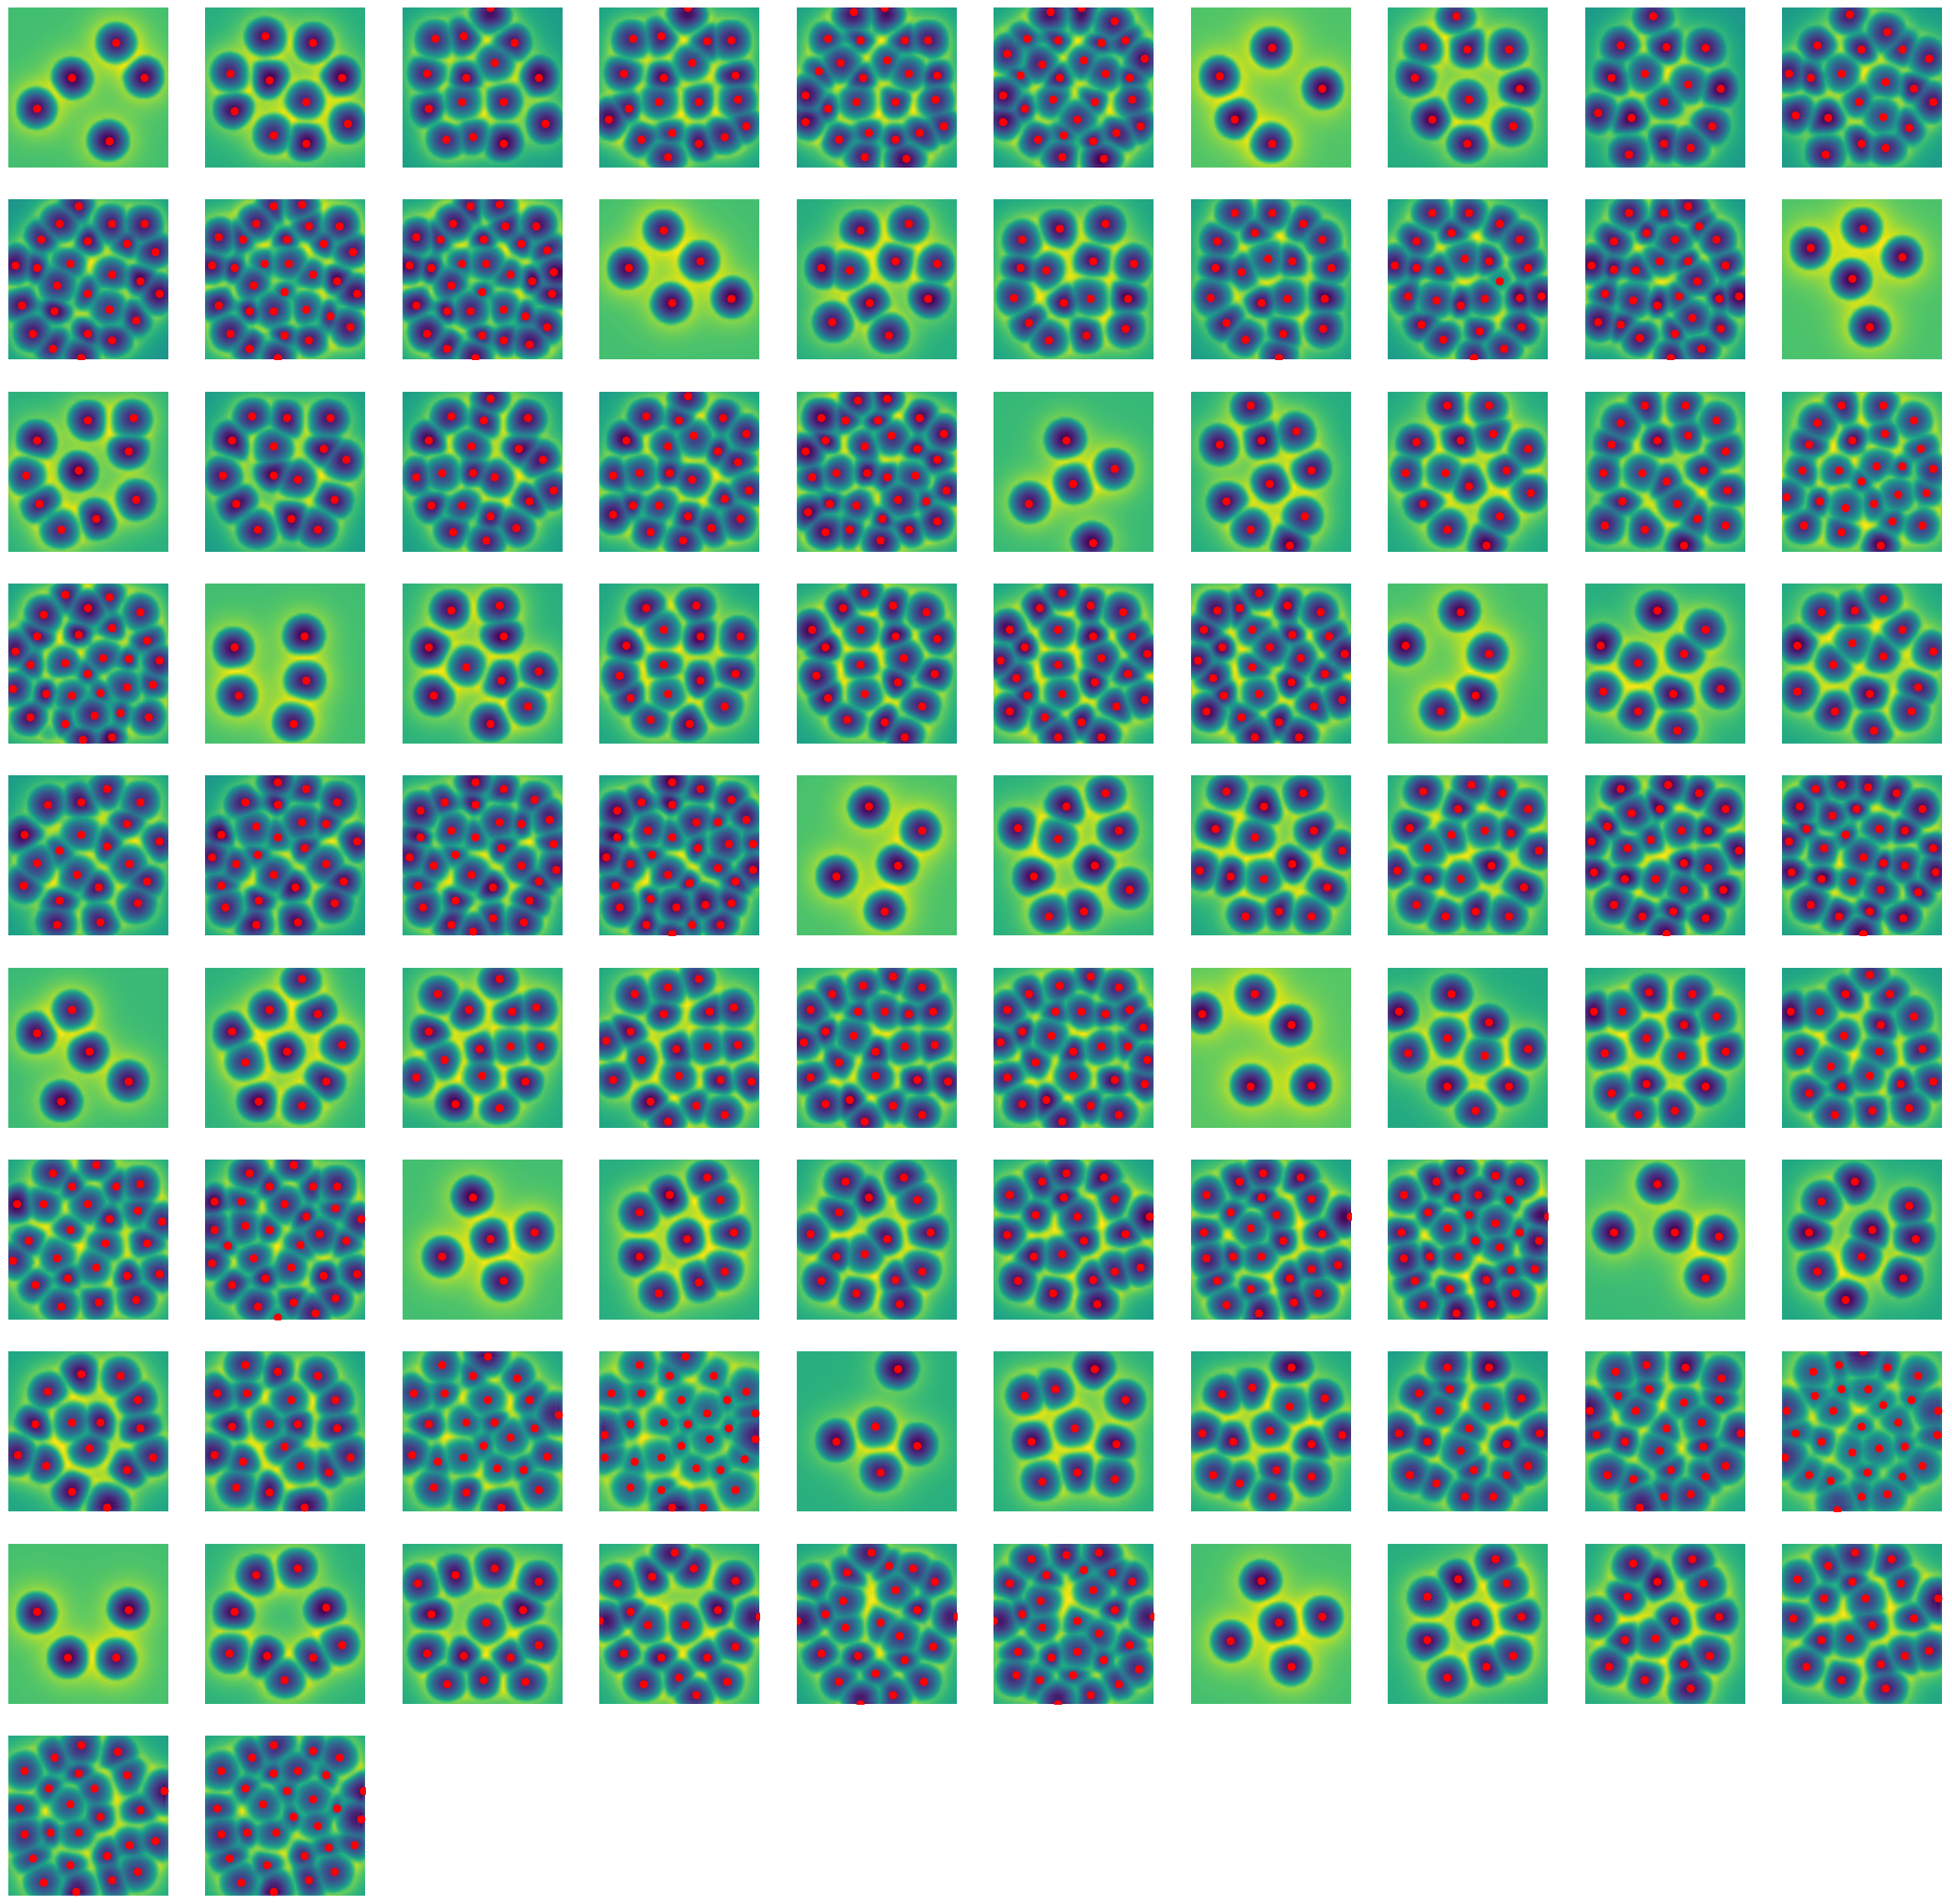

In [29]:
# fig, ax = plt.subplots(10, 10, dpi=100, figsize=(30,30))

# coord_list = []
# for i in range(100):
#     axi = np.unravel_index(i, (10,10))
#     if i<=91:
#         ax[axi].imshow(znew[i], origin='lower')
#         ax[axi].scatter(minima_arr[i][:,1], 
#                         minima_arr[i][:,0],
#                         color='red')
#     ax[axi].axis('off')

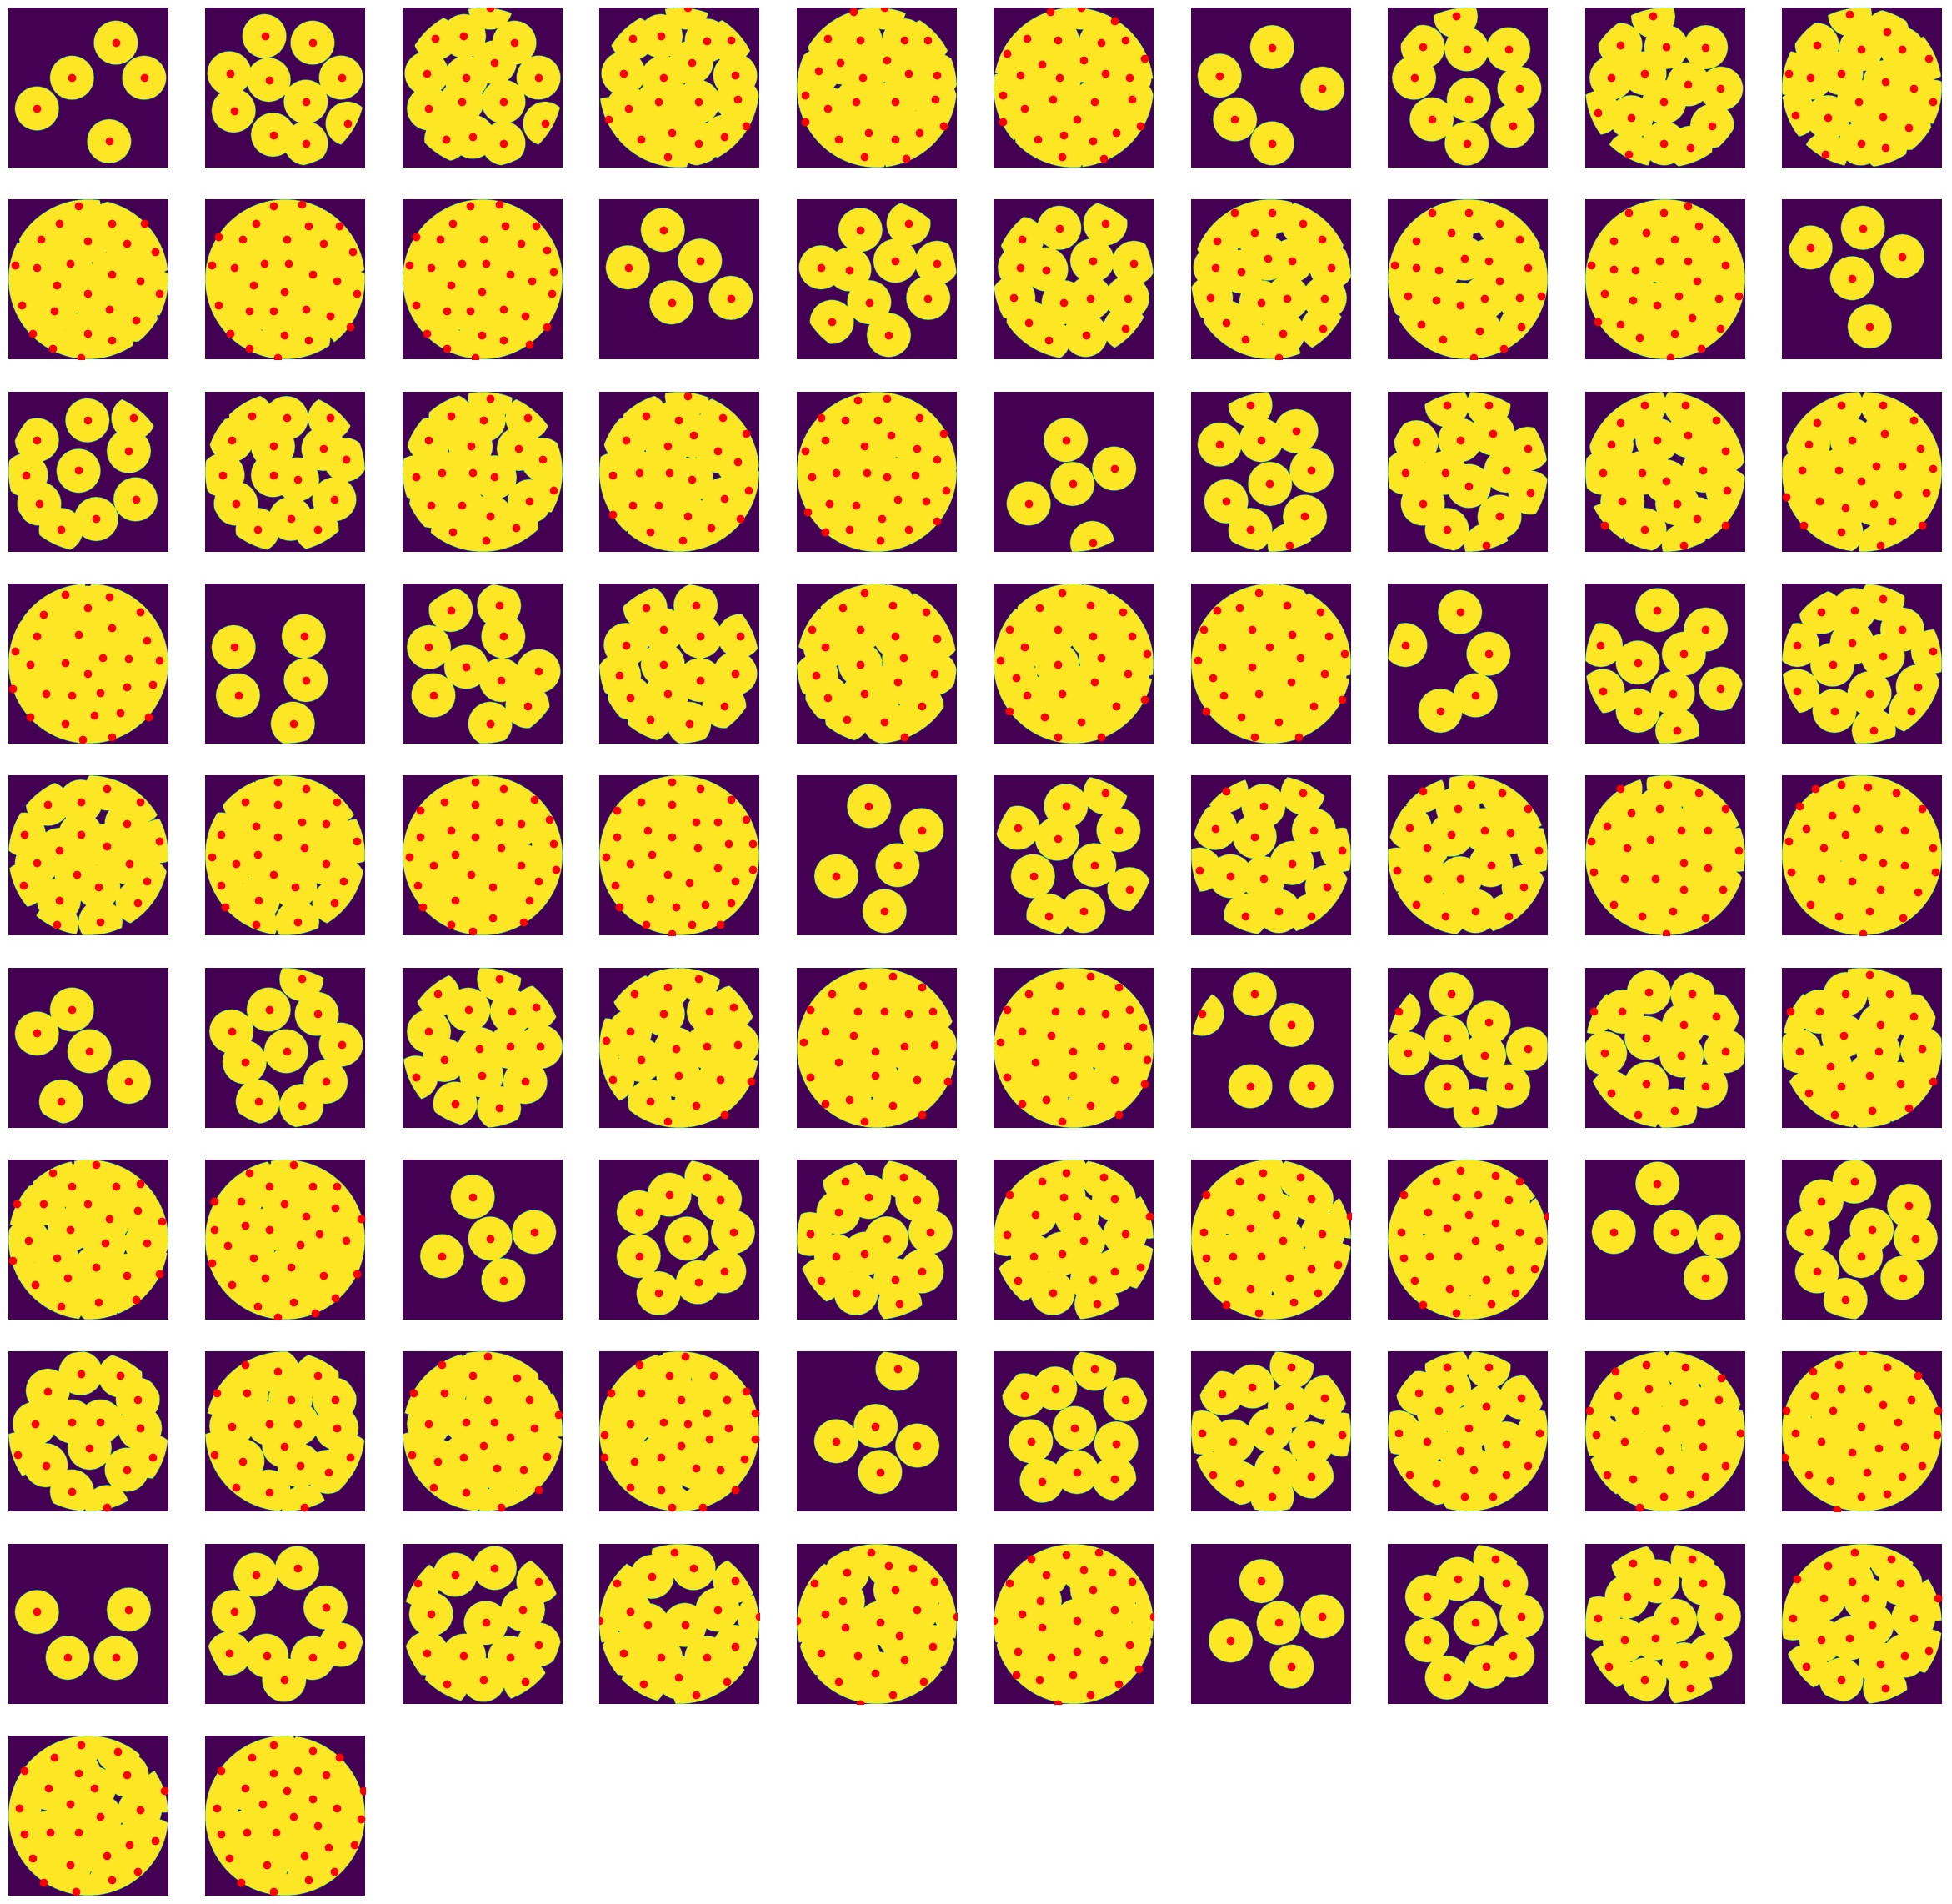

In [30]:
# fig, ax = plt.subplots(10, 10, dpi=100, figsize=(30,30))

# coord_list = []
# for i in range(100):
#     axi = np.unravel_index(i, (10,10))
#     if i<=91:
#         ax[axi].imshow(mask_list[i], origin='lower')
#         ax[axi].scatter(minima_arr[i][:,1], 
#                         minima_arr[i][:,0],
#                         color='red')
#     ax[axi].axis('off')

<!-- DO THE REST: -->